In [179]:
# Import of the packages
import numpy as np
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import math
import scipy.stats as sts
from numpy import linalg

In [2]:
class ParameterValueError(Exception):
    """ Custom exception raised when a parameter has an invalid value."""
    pass

In [225]:
# RVM class
class RVM:
    """ Relevance Vector Machine (RVM)
    
    Implementation of RVM for both regression and classification.
    
    Attributes:
        kerType: A string of the type of the desired kernel.
        rvmType: A string denoting the RVM type to be used. The string "EM" denotes
            an EM-like algorithm will be used to estimate the hyperparameters while
            the string "DD" denotes the direct differentiation approach.
        p: Integer value denoting the degree of the polynomial kernel.
        sigma: Float value denoting the smoothing factor of the Gaussian kernel.
        kappa: Float value denoting the scaling parameter of the sigmoid kernel.
        delta: Float value denoting the translation parameter of the sigmoid kernel.
        bTrained: boolean value which becomes true once the RVM has been trained.
    """

    EPSILON_CONV = 1e-10
    EPSILON_UF = 1e-20
    TH_RV = 5e7
    INFINITY = 1e20
    maxEpochs = 5000
    
    def __init__(self, kerType = 'poly', rvmType = "EM", p = 1, sigma = 1, 
                 kappa = 1, delta = 1):
        """ Initializes the RVM class (constructor).
        
            Raises:
                ParameterValueError: An error occured because a parameter had an
                    invalid value.  
        """
        # Check if the kernel type chosen is valid
        kerTypes = ['linear', 'poly', 'radial', 'sigmoid']
        if kerType not in kerTypes:
            raise ParameterValueError("ParameterValueError: The string " + kerType + \
                                       " does not denote a valid kernel type")
        # Check if the string denoting the rvmType has a valid value
        if rvmType != 'EM' and rvmType != 'DD':
            raise ParameterValueError('ParameterValueError: ' + rvmType, \
                                       " is not a valid RVM type value. Enter 'EM' or 'DD' as a value. ")
       
        self.kerType = kerType
        self.rvmType = rvmType
        self.p = p
        self.sigma = sigma
        self.kappa = kappa
        self.delta = delta
        self.bTrained = False

    def kernel(self, x, y):
        """ Kernel computation.
        
        It computes the kernel value based on the dot product
        between two vectors.
        
        Args:
            x: Input vector.
            y: Other input vector.
            
        Returns:
            The computed kernel value.
        """  
        if self.kerType == "linear":
            k = np.dot(x,y) + 1
        elif self.kerType == "poly":
            k = (np.dot(x,y) + 1) ** self.p
        elif self.kerType == "radial":
            k = math.exp(-(np.dot(x-y,x-y))/(2*self.sigma))
        elif self.kerType == "sigmoid":
            k = math.atanh(self.kappa * np.dot(x,y) - self.delta)

        return k
    
    def getKernelMatrix(self, X, training = True):
        """ Evaluates the kernel matrix K given a set of input samples (training).

            Args:
                X_tr: A NxM matrix with a M dimensional training input sample
                    in each row.
                
            Returns:
                An NxN Kernel matrix where N is the number of input samples.
        """
        N = X.shape[0]
        if training == True:
            K = np.zeros((N, N))
            for i in range(N):
                for j in range(N):
                    K[i,j] = self.kernel(X[i], X[j])
        else:
            N_sv = self.X_sv.shape[0]
            K = np.zeros((N,N_sv))
            for i in range(N):
                for j in range(N_sv):
                    K[i,j] = self.kernel(X[i], self.X_sv[j])
        return K

    def getGammaValues(self, alpha_values, Sigma):
        """Evaluates the gamma values.
        
            Args:
                alpha_values: N-dimensional vector with the hyperparameters of
                    the marginal likelihood.
                Sigma: NxN covariance matrix of the posterior
                
            Returns: A N-dimensional vector with the gamma values where 
                gamma_values[i] = 1 - alpha_values[i] * Sigma[i][i]
        """
        N = alpha_values.shape[0]
        gamma_values = 1 - np.multiply(alpha_values, np.diag(Sigma))
        return gamma_values
        
    def train(self, X_tr, Y_tr):
        """ RVM training method
        
        Applies an EM-like algorithm or direct differentiation to estimate the
        optimal hyperparameters (alpha and sigma) needed to make predictions
        using the marginal likelihood.
        
        
        Args:
            X_tr: A matrix with a training input sample in each row.
            Y_tr: A vector with the output values of each input sample
                in X_tr.
        
        Returns:
            None
        """
        # Get number of training data samples
        N = X_tr.shape[0]
        # Initialize the alpha values (weight precision values) and the A matrix
        alpha_values = np.ones(N + 1)
        A = np.diag(alpha_values)
        # Initialize the sigma squared value and the B matrix
        sigma_squared = 1
        B = np.identity(N) / sigma_squared
        # Calculate kernel matrix K and append a column with ones in the front (for the bias term??)
        K = self.getKernelMatrix(X_tr)        
        K = np.hstack((np.ones(N).reshape((N, 1)), K))
        # Calculate Sigma and mu based on the initialized parameters
        try:
            Sigma = np.linalg.inv(K.T.dot(B).dot(K) + A)
        except linalg.LinAlgError:
            Sigma = np.linalg.pinv(K.T.dot(B).dot(K) + A)
        mu = Sigma.dot(K.T).dot(B).dot(Y_tr)
        # Calculate initial gamma values
        gamma_values = self.getGammaValues(alpha_values, Sigma)
    

        # Approximate optimal hyperparameter values iteratively
        next_alpha_values = np.zeros(N + 1)
        for epoch in range(self.maxEpochs):
            # Evaluate alpha values
            if self.rvmType == "EM":
                cond_low = (np.diag(Sigma) + mu**2) < self.EPSILON_UF
                cond_high = (np.diag(Sigma) + mu**2) > self.INFINITY
                ncond = np.logical_and(np.logical_not(cond_low), np.logical_not(cond_high))
                next_alpha_values[cond_low] = self.INFINITY
                next_alpha_values[cond_high] = 0
                next_alpha_values[ncond] = 1 / (np.diag(Sigma)[ncond] + mu[ncond]**2)
            elif self.rvmType == "DD":
                cond_low = (mu**2) < self.EPSILON_UF
                cond_high = (mu**2) > self.INFINITY
                ncond = np.logical_and(np.logical_not(cond_low), np.logical_not(cond_high))
                next_alpha_values[cond_low] = self.INFINITY
                next_alpha_values[cond_high] = 0
                next_alpha_values[ncond] = gamma_values[ncond] / (mu[ncond]**2)
            # Evaluate sigma value
            next_sigma_squared = (np.linalg.norm(Y_tr - K.dot(mu)) ** 2) / (N - np.sum(gamma_values))
            # Check if algorithm has converged (variation of alpha and sigma)
            if (np.sum(np.absolute(next_alpha_values - alpha_values)) < self.EPSILON_CONV and
                abs(next_sigma_squared - sigma_squared) < self.EPSILON_CONV):
                    break
            # If algorithm has not converged, update all the variables
            alpha_values = next_alpha_values
            sigma_squared = next_sigma_squared
            A = np.diag(alpha_values)
            B = np.identity(N) / sigma_squared
            try:
                Sigma = np.linalg.inv(K.T.dot(B).dot(K) + A)
            except linalg.LinAlgError:
                Sigma = np.linalg.pinv(K.T.dot(B).dot(K) + A) 
            mu = Sigma.dot(K.T).dot(B).dot(Y_tr)
            gamma_values = self.getGammaValues(alpha_values, Sigma)
            #print("EPOCH: " + str(epoch))
        print(epoch)
            
        # We store the support vectors and other important variables
        cond_sv = alpha_values < self.TH_RV
        self.X_sv = X_tr[cond_sv[1:N+1]]
        self.Y_sv = y_tr[cond_sv[1:N+1]]
        self.mu = mu[cond_sv]
        self.bTrained = True
    
    def pred(self, X):
        """Predicts the classes for a number of input data
        
        Args:
            X: matrix with input data where each row represents a sample.
            
        Returns:
            y: vector with the predicted class for each input sample.
            
        Raises:
            UntrainedModelError: Error that occurs when this function is called
                before calling the 'train' function.
        """
        
        if self.bTrained == False:
            raise UntrainedModelError("UntrainedModelError: The SVM model has not been trained.")
        
        N = X.shape[0]
        K = self.getKernelMatrix(X, training = False)  
        N_sv = np.shape(self.X_sv)[0]
        if np.shape(self.mu)[0] != N_sv:
            K = np.hstack((np.ones(N).reshape((N, 1)), K))
        y = K.dot(self.mu)
        return y

    def getSV(self):
        return self.X_sv, self.Y_sv
               

In [79]:
def printTest(X,Y,X_tst,Y_tst,X_sv,Y_sv):
    plt.plot(X,Y,'go')
    plt.plot(X_tst, Y_tst, 'b')
    plt.plot(X_sv, Y_sv, 'ko', markersize = 15, mfc = "None")
    plt.legend(['Training points', \
                'Regression', \
                'Support Vectors'])
    plt.show()

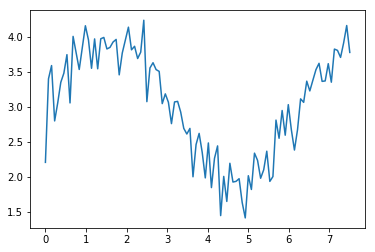

In [219]:
N_tr = 100
N_ts = 1000

def trans(x):
    N = np.shape(x)[0]
    y = np.sin(x) + 3 + np.random.normal(loc=0, scale=0.3, size=N)
    return y 

def transPoly(x):
    N = np.shape(x)[0]
    y = 0.05*x**3 - 0.35*x**2 + np.random.normal(loc=0, scale=0.1, size=N)
    return y

x_tr = np.linspace(0,7.5,num=N_tr)
y_tr = trans(x_tr)
x_ts = np.linspace(0,7.5,num=N_ts)
y_ts = trans(x_ts)
plt.plot(x_tr, y_tr)
plt.show()

1883


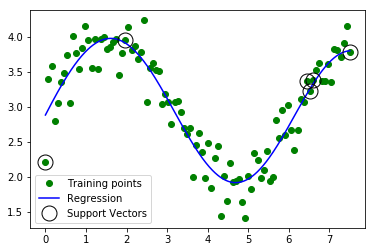

In [229]:
try:
    s = RVM(kerType = "radial", p = 2, sigma = 3, rvmType = "DD")
    s.train(x_tr, y_tr)
    y_pred = s.pred(x_ts)
    x_sv, y_sv = s.getSV()
    printTest(x_tr,y_tr,x_ts,y_pred ,x_sv,y_sv)
except Exception as e:
    print(e)
    

267


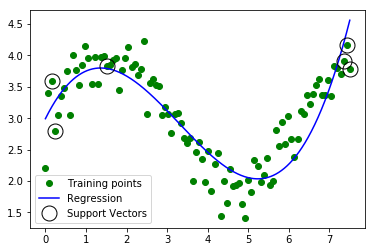

In [228]:
s = RVM(kerType = "poly", p = 3, sigma = 1.1, rvmType = "DD")
s.train(x_tr, y_tr)
y_pred = s.pred(x_ts)
x_sv, y_sv = s.getSV()
printTest(x_tr,y_tr,x_ts,y_pred ,x_sv,y_sv)

In [15]:
not True

False

In [37]:
a = np.array([True, True, False])
np.logical_not(a)

array([False, False,  True], dtype=bool)